In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import io
import itertools

import re
import string
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import os
import time

In [10]:
os.chdir("E:/200_CASA/13_i2p-py/CW3")
os.getcwd()

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('science') # specifies that graphs should use science styling

In [7]:
def set_proxy(port):
    tz = time.strftime('%z')
    ## if in china 
    if tz == "+0800": 
        os.environ['HTTP_PROXY'] = f'http://127.0.0.1:{port}'
        os.environ['HTTPS_PROXY'] = f'http://127.0.0.1:{port}'
        print("proxy setted")
    else:
        print(f"Time zone: {tz}")

set_proxy(10809)

proxy setted


# load data

## load POI data

poi classes:
* 01 Accommodation, eating and drinking
* 02 Commercial services
* 03 Attractions
* 04 Sport and entertainment
* 05 Education and health
* 06 Public infrastructure
* 07 Manufacturing and production
* 09 Retail
* 10 Transport

In [506]:
def load_gpoi(path,cols=["ref_no","name","pointx_class","geometry"]):
    dfpoi = pd.read_csv(path,low_memory=False)
    gdf = gpd.GeoDataFrame(dfpoi,geometry=gpd.points_from_xy(dfpoi["feature_easting"],dfpoi['feature_northing'], 
                                                             crs='epsg:27700'))[cols]
    return gdf

In [507]:
gpoi = load_gpoi(os.path.join('data','poi_3822536','poi2020_09.csv'))

In [508]:
gpoi["class"] = gpoi.apply(lambda x:int(re.findall(r"(\d+)\d{6}$",str(int(x["pointx_class"])))[0]), axis=1)

In [513]:
# counts for different class
gpoi.groupby("class").agg("count")

,ref_no,name,pointx_class,geometry
class,,,,
1,38676,38676,38676,38676
2,167334,167334,167334,167334
3,24253,24253,24253,24253
4,16419,16419,16419,16419
5,38437,38437,38437,38437
6,74174,74174,74174,74174
7,29840,29840,29840,29840
9,56582,56582,56582,56582
10,44911,44911,44911,44911


(174000.0, 188000.0)

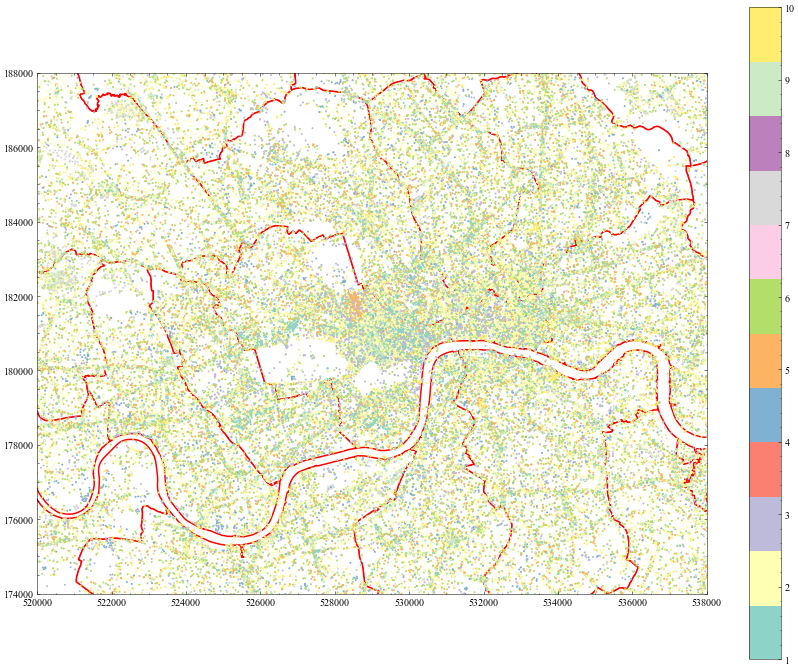

In [512]:
# plot the spatial distribution of different classes of pois
fig,ax=plt.subplots(figsize=(15,12))
boros = gpd.read_file('../data/geo/Boroughs.gpkg')
boros.plot(edgecolor='red', facecolor='white', linewidth=1.5,ax=ax)
gpoi.plot(column='class', cmap='Set3', markersize=1, ax=ax,legend=True)
ax.set_xlim([520000,538000])
ax.set_ylim([174000,188000])

In [18]:
gpoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 490626 entries, 0 to 490625
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   ref_no        490626 non-null  int64   
 1   pointx_class  490626 non-null  int64   
 2   geometry      490626 non-null  geometry
dtypes: geometry(1), int64(2)
memory usage: 11.2 MB


## load inside Airbnb data

In [464]:
def load_bnb(path):
    '''
    load gbnb from bnb
    '''
    if not os.path.exists(path):
        bnb = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings.csv.gz?raw=true',
                          compression='gzip', low_memory=False)
        bnb.to_csv(path,compression='gzip')
        print("File Downloaded.")
        
    bnb = pd.read_csv(path,compression='gzip', low_memory=False)
    print("File loaded")
    print(f"BNB Data frame is {bnb.shape[0]} x {bnb.shape[1]}")
    return bnb

def load_gbnb(bnb,cols=['room_type','longitude','latitude','price']):
    bnb = bnb[cols]
    gbnb = gpd.GeoDataFrame(bnb, geometry=gpd.points_from_xy(bnb["longitude"], bnb['latitude'], crs='epsg:4326'))
    gbnb = gbnb.to_crs('epsg:27700')
    print(f"GBNB Data frame is {bnb.shape[0]} x {bnb.shape[1]}")
    return gbnb

In [465]:
bnb = load_bnb(os.path.join('data','bnb.csv.gz'))
gbnb = load_gbnb(bnb)

File loaded
BNB Data frame is 74120 x 54
GBNB Data frame is 74120 x 5


In [466]:
gbnb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74120 entries, 0 to 74119
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   room_type  74120 non-null  object  
 1   longitude  74120 non-null  float64 
 2   latitude   74120 non-null  float64 
 3   price      74120 non-null  float64 
 4   geometry   74120 non-null  geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 2.8+ MB


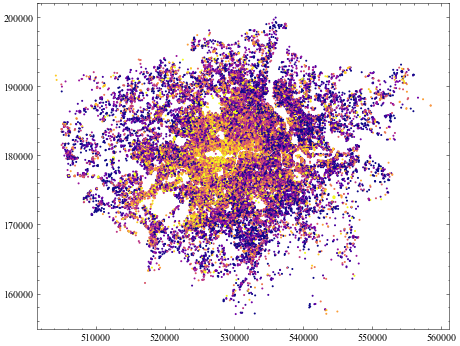

In [463]:
gbnb.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));

In [467]:
def get_vocab(words):
    vocab, index = {}, 1 
    vocab['<pad>'] = 0
    for token in words:
        if token not in vocab: 
            vocab[token] = index
            index += 1
    vocab_size = len(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab,inverse_vocab,vocab_size 

In [468]:
vocab,inverse_vocab,vocab_size = get_vocab(gpoi.pointx_class.unique())

In [469]:
def get_sequences(gdf_bnb, gdf_poi, vocab, buf_dis = 100):
    '''
    buf_dis: buffer distance 
    '''
    sequences={}
    for bnb_ind in tqdm.tqdm(range(len(gdf_bnb))):
        # create buffer area
        buffer = gdf_bnb.geometry[bnb_ind].buffer(buf_dis) 
        # get pois in buffer area
        buf_pois = gdf_poi[gdf_poi.within(buffer)] 

        if buf_pois.shape[0]>0:
            # get distanace for each pois in buffer area
            buf_pois["dis_to_bnb"] = buf_pois.apply(lambda x: gdf_bnb.geometry[bnb_ind].distance(x.geometry),axis=1)
            # sort by distance 
            buf_pois_sort = buf_pois.sort_values(by="dis_to_bnb").reset_index()
            sequence = [vocab[word] for word in buf_pois_sort.pointx_class]
            sequences[bnb_ind] = np.array(sequence, dtype=int)
    return sequences

In [470]:
gbnb_EnH = gbnb[(gbnb.price>0)& (gbnb.room_type=="Entire home/apt")].reset_index(drop=True)

In [471]:
sequences_EnH  = get_sequences(gbnb_EnH, gpoi, vocab, buf_dis=300)

  0%|          | 0/40832 [00:00<?, ?it/s]D:\Miniconda\envs\sds20\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
100%|██████████| 40832/40832 [27:12<00:00, 25.01it/s]


In [78]:
np.save("data/Sequences_EntireHome.npy", sequences_EnH) # bnb index as index sequenceas  key

In [366]:
sequences_EnH=np.load("data/Sequences_EntireHome.npy",allow_pickle=True).item()

In [367]:
sequences_EnH = {k:v for k,v in sequences_EnH.items() if len(v)>5}

## verify zipf law

<AxesSubplot:>

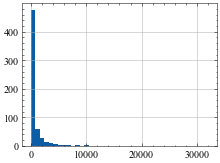

In [296]:
gpoi.pointx_class.value_counts().hist(bins=40)

# Word2Vec

* 更近的作用更大
* 对于更poi更密集的地区 作用更大
* https://juejin.cn/post/6844903666378342407

In [387]:
# Parameters
SEED = 42 
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
WINDOW_SIZE=5
NUM_NS = 4
embedding_dim = 200
vocab_size=620

In [388]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=SEED, 
                name="negative_sampling")

        # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [389]:
len([x for x in sequences_EnH.values() if len(x)==6])

1806

In [390]:
sequences = [x for x in sequences_EnH.values()]

(array([1.2556e+04, 5.2590e+03, 3.3290e+03, 2.6960e+03, 1.8160e+03,
        1.3950e+03, 1.0090e+03, 9.1900e+02, 6.1200e+02, 4.5700e+02,
        3.8200e+02, 2.8900e+02, 2.5300e+02, 2.2700e+02, 2.0600e+02,
        1.6300e+02, 1.1800e+02, 1.1800e+02, 6.2000e+01, 5.3000e+01,
        2.8000e+01, 3.7000e+01, 1.8000e+01, 1.6000e+01, 1.0000e+01,
        8.0000e+00, 1.0000e+01, 8.0000e+00, 1.0000e+01, 8.0000e+00,
        4.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 1.0000e+00,
        3.0000e+00, 4.0000e+00, 0.0000e+00, 6.0000e+00, 5.0000e+00,
        3.0000e+00, 4.0000e+00, 6.0000e+00, 1.0000e+00, 2.0000e+00,
        5.0000e+00, 5.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([  6.  ,  17.28,  28.56,  39.84,  51.12,  62.4 ,  73.68,  84.96,
         96.24, 107.52, 118.8 , 130.08, 141.36, 152.64, 163.92, 175.2 ,
        186.48, 197.76, 209.04, 220.32, 231.6 , 242.88, 254.16, 265.44,
        276.72, 288.  , 299.28, 310.56, 321.84, 333.12, 344.4 , 355.68,
        366.96, 378.24, 389.52

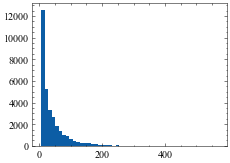

In [391]:
# sequences length distribution 
lens = [len(x) for x in sequences]
plt.hist(lens,bins=50)

In [392]:
targets, contexts, labels = generate_training_data(sequences=sequences, 
                                                   window_size=WINDOW_SIZE, 
                                                   num_ns=NUM_NS, 
                                                   vocab_size=vocab_size, 
                                                   seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 32139/32139 [00:58<00:00, 549.14it/s]

904984 904984 904984


In [393]:
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [394]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [395]:
class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size, 
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding", )
        self.context_embedding = Embedding(vocab_size, 
                                           embedding_dim, 
                                           input_length=NUM_NS+1)
        self.dots = Dot(axes=(3,2))
        self.flatten = Flatten()

    def call(self, pair):
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        return self.flatten(dots)

In [396]:
# def custom_loss(x_logit, y_true):
#       return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [397]:
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [398]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [399]:
word2vec.fit(dataset, epochs=50, callbacks=[tensorboard_callback])

Epoch 1/50
883/883 [==============================] - 5s 6ms/step - loss: 0.9055 - accuracy: 0.6549
Epoch 2/50
883/883 [==============================] - 4s 5ms/step - loss: 0.8122 - accuracy: 0.6790
Epoch 3/50
883/883 [==============================] - 5s 5ms/step - loss: 0.8010 - accuracy: 0.6836
Epoch 4/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7928 - accuracy: 0.6868
Epoch 5/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7855 - accuracy: 0.6897
Epoch 6/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7790 - accuracy: 0.6923
Epoch 7/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7731 - accuracy: 0.6945
Epoch 8/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7679 - accuracy: 0.6965
Epoch 9/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7633 - accuracy: 0.6982
Epoch 10/50
883/883 [==============================] - 4s 5ms/step - loss: 0.7592 - accuracy: 0.6998

In [400]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

In [403]:
word2vec.save(f"model/word2vec_seq{5}_{WINDOW_SIZE}_{NUM_NS}.w2v")

INFO:tensorflow:Assets written to: model/word2vec_seq5_5_4.w2v\assets


In [404]:
out_v = io.open('data/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('data/words.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if  index == 0: continue # skip 0, it's padding.
    vec = weights[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(str(word) + "\n")
out_v.close()
out_m.close()

# Vec exploring
https://github.com/danielfrg/word2vec/tree/master/word2vec

# POI Vector Clustering

In [406]:
vec = pd.read_csv('data/vectors.tsv', sep='\t',names=[i+1 for i in range(200)])
word = pd.read_csv('data/words.tsv', sep='\t',names=["word"])

In [407]:
poivec = pd.merge(word,vec,left_index=True, right_index=True)

In [408]:
poivec["class"] = poivec.apply(lambda x:int(re.findall(r"(\d+)\d{6}$",str(int(x["word"])))[0]), axis=1)

In [409]:
poivec

,word,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,class
0,6340456,-0.7582,-0.2463,0.1734,-0.6577,-1.5458,0.2513,0.2543,-0.3525,-0.7899,...,0.7330,0.6345,1.1752,-0.3399,-0.0882,-0.0172,0.7131,0.1028,0.1729,6
1,6340459,-0.5585,-0.0892,0.3612,-0.0792,-0.6740,0.5489,-0.1473,-0.3482,-0.1248,...,0.7401,0.6804,0.2181,-0.3212,-0.3110,0.1498,-0.4026,0.3860,0.0756,6
2,6350450,-0.9315,-0.2883,-0.0955,-0.0905,-0.5607,-0.6094,-0.1927,-0.2095,0.3118,...,0.0647,-0.3175,0.7019,0.2776,-0.1123,-0.3196,0.0552,0.8754,-0.4693,6
3,3170244,-0.3082,0.0783,0.3032,-0.4962,-1.0370,-1.1249,0.6776,0.0254,0.2051,...,0.1772,-0.3130,-0.0421,0.3435,0.1653,-0.1168,0.6351,0.3762,0.8532,3
4,1020012,-0.6816,-0.0429,0.6779,0.2765,-0.1227,0.6122,-0.0586,-0.5030,0.5016,...,0.3324,1.3746,0.4055,-1.0086,0.5975,0.1962,0.4518,0.2329,-0.4025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,6340438,0.0015,0.0141,0.0193,0.0490,0.0417,-0.0041,0.0086,0.0164,-0.0082,...,0.0122,0.0164,0.0079,-0.0132,-0.0349,-0.0365,0.0169,-0.0347,-0.0268,6
606,6340455,0.0288,-0.0002,0.1013,0.2381,-0.3496,0.3170,0.1177,-0.6899,0.2113,...,0.3150,-0.0940,0.2014,0.2187,0.2302,0.4238,-0.3540,-0.1426,0.3097,6
607,10540740,-0.1785,0.1353,-0.0414,-0.5544,-0.0365,-0.3979,0.3511,-0.0146,-0.8717,...,-0.0639,-0.1811,0.6959,-0.3580,0.2010,-0.0023,0.3216,-0.2681,0.1228,10
608,7410536,-0.4213,0.5914,0.0911,0.6027,0.3345,0.5651,-0.2671,1.1625,-0.6054,...,-0.5385,0.4159,0.5616,-0.5302,0.7573,-0.6324,-0.6725,-0.1695,2.1747,7


## Cosine-distance-based K-Means  

In [410]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# from sklearn_extra.cluster import KMedoids # doesn't work

In [411]:
from sklearn.cluster import k_means_
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.preprocessing import StandardScaler

def CosKMeans(nclust = 4):
    # Manually override euclidean
    def euc_dist(X, Y = None, Y_norm_squared = None, squared = False):
        #return pairwise_distances(X, Y, metric = 'cosine', n_jobs = 10)
        return cosine_similarity(X, Y)
    k_means_.euclidean_distances = euc_dist

    kmeans = k_means_.KMeans(n_clusters = nclust, random_state = 3425)
    return kmeans

In [412]:
kmeans_per_k = [CosKMeans(nclust= k).fit(poivec.iloc[:,1:201]) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Text(0.55, 0.55, 'Elbow')

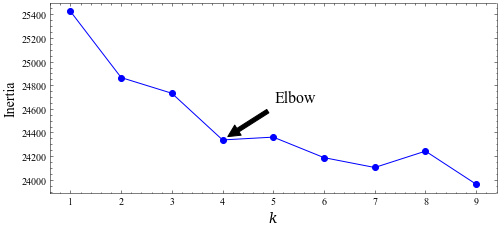

In [416]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.axis([1, 8.5, 0, 1300])
# plt.show()

Text(0, 0.5, 'Silhouette score')

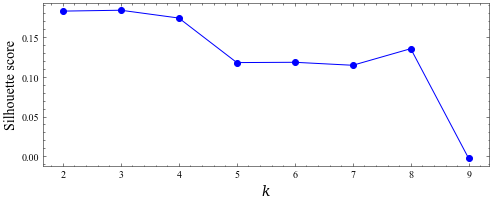

In [415]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(poivec.iloc[:,1:201], model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

In [417]:
poivec["clu"] = CosKMeans(nclust= 4).fit(poivec.iloc[:,1:201]).labels_
pd.crosstab(poivec["clu"],poivec["class"])

class,1,2,3,4,5,6,7,9,10
clu,,,,,,,,,
0,2,2,1,1,0,0,2,0,0
1,0,3,2,3,1,0,4,3,1
2,13,142,22,29,54,40,94,64,20
3,0,27,6,7,8,8,39,1,11


In [420]:
poivec["clu"] = CosKMeans(nclust= 5).fit(poivec.iloc[:,1:201]).labels_
pd.crosstab(poivec["clu"],poivec["class"])

class,1,2,3,4,5,6,7,9,10
clu,,,,,,,,,
0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,1,0
2,1,18,4,2,4,2,26,2,1
3,13,122,20,29,50,36,74,60,22
4,1,33,7,9,9,9,39,5,9


In [ ]:
poivec["clu"] = CosKMeans(nclust= 10).fit(poivec.iloc[:,1:201]).labels_
pd.crosstab(poivec["clu"],poivec["class"])

In [ ]:
poivec.to_csv()

## Explore poi vec

## BNB vector clustering

In [422]:
list(sequences_EnH.items())[3330] # check

(4326,
 array([ 13, 357, 132, 166, 112, 210, 210,  70, 111, 395, 112, 112, 183,
        117, 465, 141, 177, 158,  35, 141, 141, 170]))

In [427]:
entityvecs = {}
for k,v in tqdm.tqdm(sequences_EnH.items()):
    entityvec = np.zeros([1,200])
    for vecindex in v:
        entityvec += np.array(poivec.iloc[vecindex-1,1:201]) ## vecindex from 1 to 610
    entityvecs[k] = entityvec
## TODO: use numpy array data strcutre to speed up sum

100%|██████████| 32139/32139 [05:24<00:00, 98.96it/s] 


In [428]:
out_v = io.open('data/BnbVecs.tsv', 'w', encoding='utf-8')
for k,v in entityvecs.items():
    out_v.write(str(k) +'\t'+ '\t'.join([str(x) for x in v[0]]) + "\n")
out_v.close()

In [431]:
gbnb_EnH_vector = pd.read_csv('data/BnbVecs.tsv', sep='\t',names=["gbnb_EnH_index"]+[str(i+1) for i in range(200)])

In [432]:
gbnb_EnH_vector

,gbnb_EnH_index,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,0,-2.9449,1.5212,0.0483,-2.1444,-1.1753,-0.4945,0.6321,-0.8618,-2.8431,...,-2.3408,0.9177,1.9914,0.3718,-2.3429,1.5758,-2.7087,-0.2758,2.3727,-0.0318
1,1,-11.6237,7.0945,-5.1090,-6.5019,-1.5580,-0.8366,12.6137,-3.9498,-3.4054,...,-9.1683,9.1033,7.8440,4.6471,-6.2947,11.2215,-10.0740,-8.1717,4.2112,9.9836
2,2,-8.4176,4.8717,-7.6132,-6.8365,-3.0819,-7.2276,5.8395,-0.4243,-4.5868,...,-6.3098,0.2753,5.6802,5.8247,-4.3020,5.0855,-1.7278,-3.9700,4.5643,4.7854
3,3,-0.9681,0.1950,-0.3047,-0.8868,-0.5484,-0.5224,0.6256,0.1665,-0.9695,...,-1.1818,0.9961,0.7367,0.2879,-0.9626,0.6212,-0.4301,-1.6933,0.1417,0.7783
4,4,-5.4855,0.4241,-2.0518,-0.7215,-2.3197,-2.2491,-0.1644,0.0066,-2.9074,...,-2.4247,3.8579,4.7579,4.3530,-5.1610,2.4104,-1.3096,-2.4675,1.2051,1.5054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32134,40826,-4.2979,4.7308,-1.7553,-3.7397,-1.4616,-2.2870,1.3708,-4.5862,-3.9764,...,-0.6351,1.7746,2.7367,0.7975,-5.7171,0.7841,-0.4261,-5.1328,3.2399,4.7588
32135,40827,0.4566,-0.0315,-1.3631,0.1358,-0.2749,-0.9569,-0.6355,-0.7679,0.2686,...,0.6136,0.3250,0.0401,0.5797,-1.0313,0.9174,-0.6231,-1.1822,0.8102,1.0380
32136,40828,-0.9368,-0.0782,0.4513,-1.7452,-1.9027,-0.4448,0.3986,-0.0307,-1.6590,...,-0.9626,0.8162,0.9264,1.1602,-1.5199,0.2283,-0.6685,0.1679,0.6006,0.9811
32137,40830,-2.2304,1.5397,-0.1158,-2.7407,-1.6906,-2.2182,4.0539,0.3468,-0.9530,...,-3.0812,3.0143,1.9957,3.4231,-2.2370,-0.1367,-1.2903,-1.5219,4.6487,0.0106


In [235]:
# series = {}
# for k,v in tqdm.tqdm(entityvecs.items()):
#     series["key"] = k
#     for i in range(200):
#         series[str(i+1)] = v[0][i]
#     df=df.append(series, ignore_index=True) ## needed time becomes more and more longer 

### BNB vector Clustering

In [433]:
gbnb_EnH_merge = pd.merge(gbnb_EnH_vector,gbnb_EnH,left_on="gbnb_EnH_index",right_index=True,how="left")

In [456]:
gbnb_EnH_merge.to_csv("data/gbnb_EnH_merge.csv")

In [457]:
gbnb_EnH_merge

,gbnb_EnH_index,1,2,3,4,5,6,7,8,9,...,197,198,199,200,room_type,longitude,latitude,price,geometry,clu
0,0,-2.9449,1.5212,0.0483,-2.1444,-1.1753,-0.4945,0.6321,-0.8618,-2.8431,...,-2.7087,-0.2758,2.3727,-0.0318,Entire home/apt,-0.1173,51.4622,87.0000,POINT (530883.347 175377.821),0
1,1,-11.6237,7.0945,-5.1090,-6.5019,-1.5580,-0.8366,12.6137,-3.9498,-3.4054,...,-10.0740,-8.1717,4.2112,9.9836,Entire home/apt,-0.1690,51.4880,75.0000,POINT (527223.445 178145.847),3
2,2,-8.4176,4.8717,-7.6132,-6.8365,-3.0819,-7.2276,5.8395,-0.4243,-4.5868,...,-1.7278,-3.9700,4.5643,4.7854,Entire home/apt,-0.1409,51.5219,208.0000,POINT (529074.044 181974.630),2
3,3,-0.9681,0.1950,-0.3047,-0.8868,-0.5484,-0.5224,0.6256,0.1665,-0.9695,...,-0.4301,-1.6933,0.1417,0.7783,Entire home/apt,-0.2807,51.4793,195.0000,POINT (519492.622 176999.348),0
4,4,-5.4855,0.4241,-2.0518,-0.7215,-2.3197,-2.2491,-0.1644,0.0066,-2.9074,...,-1.3096,-2.4675,1.2051,1.5054,Entire home/apt,-0.0588,51.5397,80.0000,POINT (534716.316 184098.636),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32134,40826,-4.2979,4.7308,-1.7553,-3.7397,-1.4616,-2.2870,1.3708,-4.5862,-3.9764,...,-0.4261,-5.1328,3.2399,4.7588,Entire home/apt,-0.1253,51.4138,80.0000,POINT (530463.421 169974.745),0
32135,40827,0.4566,-0.0315,-1.3631,0.1358,-0.2749,-0.9569,-0.6355,-0.7679,0.2686,...,-0.6231,-1.1822,0.8102,1.0380,Entire home/apt,-0.0728,51.6534,74.0000,POINT (533418.297 196720.218),0
32136,40828,-0.9368,-0.0782,0.4513,-1.7452,-1.9027,-0.4448,0.3986,-0.0307,-1.6590,...,-0.6685,0.1679,0.6006,0.9811,Entire home/apt,-0.0421,51.4922,55.0000,POINT (536021.517 178839.794),0
32137,40830,-2.2304,1.5397,-0.1158,-2.7407,-1.6906,-2.2182,4.0539,0.3468,-0.9530,...,-1.2903,-1.5219,4.6487,0.0106,Entire home/apt,-0.2013,51.5294,150.0000,POINT (524869.818 182698.529),0


In [435]:
from sklearn.cluster import k_means_
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.preprocessing import StandardScaler

def SinKMeans(nclust = 4):
    # Manually override euclidean
    def euc_dist(X, Y = None, Y_norm_squared = None, squared = False):
        #return pairwise_distances(X, Y, metric = 'cosine', n_jobs = 10)
        return cosine_similarity(X, Y)
    k_means_.euclidean_distances = euc_dist

    kmeans = k_means_.KMeans(n_clusters = nclust, random_state = 3425)
    return kmeans

In [436]:
kmeans_per_k = [CosKMeans(nclust= k).fit(gbnb_EnH_merge.iloc[:,1:201]) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Text(0.55, 0.55, 'Elbow')

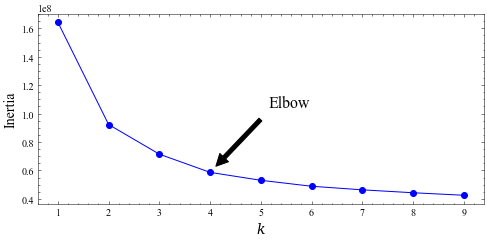

In [437]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

Text(0, 0.5, 'Silhouette score')

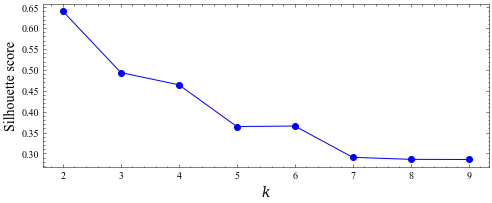

In [438]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(gbnb_EnH_merge.iloc[:,1:201], model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

In [439]:
gbnb_EnH_merge["clu"] = CosKMeans(nclust= 5).fit(gbnb_EnH_merge.iloc[:,1:201]).labels_
gbnb_EnH_merge["clu"] = gbnb_EnH_merge["clu"].astype('category')

In [440]:
gbnb_EnH_merge =gpd.GeoDataFrame(gbnb_EnH_merge)

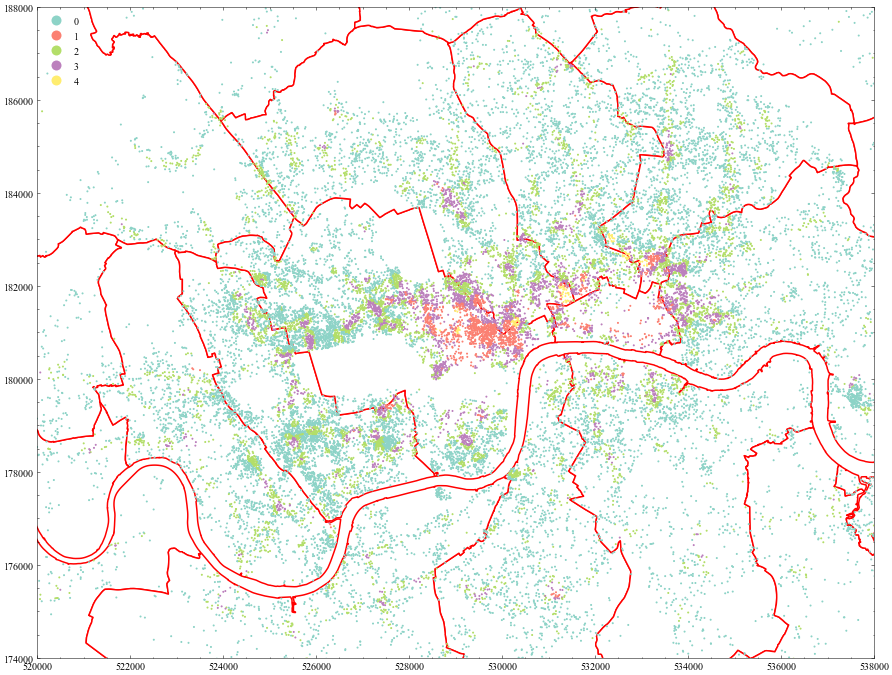

In [452]:
fig,ax=plt.subplots(figsize=(15,12))
boros = gpd.read_file('../data/geo/Boroughs.gpkg')
boros.plot(edgecolor='red', facecolor='white', linewidth=1.5,ax=ax)
gbnb_EnH_merge.plot(column='clu', cmap='Set3', markersize=1, ax=ax,legend=True)
ax.set_xlim([520000,538000])
ax.set_ylim([174000,188000])
fig.savefig("plots/seq5_clus5.png",dpi=300)

## Correlation with price

D:\Miniconda\envs\sds20\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='clu', ylabel='price'>

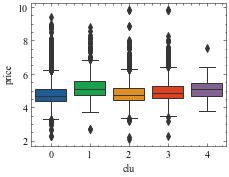

In [455]:
sns.boxplot(gbnb_EnH_merge["clu"],np.log(gbnb_EnH_merge["price"]))

## T-SNE +KMeans
Clustering on the output of t-SNE:
https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne

In [474]:
gbnb_EnH_merge = pd.read_csv("data/gbnb_EnH_merge.csv",index_col=0)

In [475]:
gbnb_EnH_merge

,gbnb_EnH_index,1,2,3,4,5,6,7,8,9,...,197,198,199,200,room_type,longitude,latitude,price,geometry,clu
0,0,-2.9449,1.5212,0.0483,-2.1444,-1.1753,-0.4945,0.6321,-0.8618,-2.8431,...,-2.7087,-0.2758,2.3727,-0.0318,Entire home/apt,-0.1173,51.4622,87.0000,POINT (530883.3467809145 175377.8210238031),0
1,1,-11.6237,7.0945,-5.1090,-6.5019,-1.5580,-0.8366,12.6137,-3.9498,-3.4054,...,-10.0740,-8.1717,4.2112,9.9836,Entire home/apt,-0.1690,51.4880,75.0000,POINT (527223.4454266732 178145.8474098458),3
2,2,-8.4176,4.8717,-7.6132,-6.8365,-3.0819,-7.2276,5.8395,-0.4243,-4.5868,...,-1.7278,-3.9700,4.5643,4.7854,Entire home/apt,-0.1409,51.5219,208.0000,POINT (529074.0439302978 181974.6297164186),2
3,3,-0.9681,0.1950,-0.3047,-0.8868,-0.5484,-0.5224,0.6256,0.1665,-0.9695,...,-0.4301,-1.6933,0.1417,0.7783,Entire home/apt,-0.2807,51.4793,195.0000,POINT (519492.6222102777 176999.3478735178),0
4,4,-5.4855,0.4241,-2.0518,-0.7215,-2.3197,-2.2491,-0.1644,0.0066,-2.9074,...,-1.3096,-2.4675,1.2051,1.5054,Entire home/apt,-0.0588,51.5397,80.0000,POINT (534716.3160247433 184098.6358136522),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32134,40826,-4.2979,4.7308,-1.7553,-3.7397,-1.4616,-2.2870,1.3708,-4.5862,-3.9764,...,-0.4261,-5.1328,3.2399,4.7588,Entire home/apt,-0.1253,51.4138,80.0000,POINT (530463.4209888917 169974.7449671307),0
32135,40827,0.4566,-0.0315,-1.3631,0.1358,-0.2749,-0.9569,-0.6355,-0.7679,0.2686,...,-0.6231,-1.1822,0.8102,1.0380,Entire home/apt,-0.0728,51.6534,74.0000,POINT (533418.2974077105 196720.2176198161),0
32136,40828,-0.9368,-0.0782,0.4513,-1.7452,-1.9027,-0.4448,0.3986,-0.0307,-1.6590,...,-0.6685,0.1679,0.6006,0.9811,Entire home/apt,-0.0421,51.4922,55.0000,POINT (536021.5168543702 178839.7936000139),0
32137,40830,-2.2304,1.5397,-0.1158,-2.7407,-1.6906,-2.2182,4.0539,0.3468,-0.9530,...,-1.2903,-1.5219,4.6487,0.0106,Entire home/apt,-0.2013,51.5294,150.0000,POINT (524869.8184667722 182698.5285424376),0


In [477]:
from sklearn.manifold import TSNE

keep_dims=2
lrn_rate=150
prp=50

tsnedf = gbnb_EnH_merge.iloc[:,1:201].copy()

tsne = TSNE(n_components=keep_dims, perplexity=prp, random_state=42, n_iter=5000, n_jobs=-1)
X_embedded = tsne.fit_transform(tsnedf)
X_embedded.shape

(32139, 2)

In [482]:
tsne = pd.DataFrame(data=X_embedded,columns=["dim1","dim2"])
gbnb_EnH_tsne=  pd.merge(gbnb_EnH_merge,tsne,left_index=True,right_index=True)

In [488]:
kmeans_per_k = [KMeans(k).fit(gbnb_EnH_tsne.iloc[:,-2:]) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [495]:
gbnb_EnH_tsne["clu"] = kmeans_per_k[3].labels_

Text(0.55, 0.55, 'Elbow')

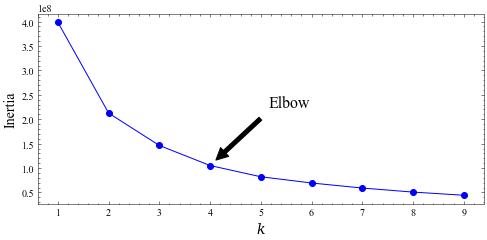

In [489]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

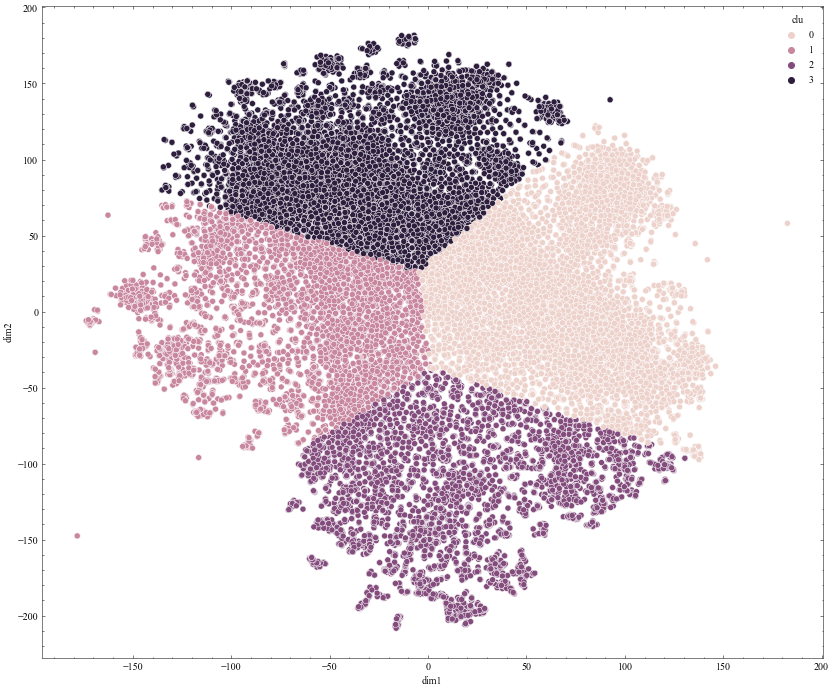

In [505]:
fig,ax=plt.subplots(figsize=(14,12))
sns.scatterplot(data= gbnb_EnH_tsne,x="dim1",y="dim2",hue="clu",ax=ax)